In [2]:
# ======================================================================
# Exemplo numérico e simulação de Monte Carlo — Regressão Poisson
# ======================================================================

# Parâmetros
n = 200
beta0 = 1
beta1 = 0.3   # valor verdadeiro
alpha = 0.05
M = 10000

# Covariável x
x = runif(n, 0, 2)

# Função auxiliar: ajuste GLM Poisson e teste H0: beta1 = 0
teste_poisson = function(y, x) {
  m_full = glm(y ~ x, family = poisson)
  m_red  = glm(y ~ 1, family = poisson)
  
  # Estatísticas de teste
  LR  = 2 * (logLik(m_full)[1] - logLik(m_red)[1])
  W   = (coef(m_full)[2] / sqrt(vcov(m_full)[2,2]))^2
  S   = NA  # (score não implementado neste exemplo simples)
  
  p_lr = 1 - pchisq(LR, 1)
  p_w  = 1 - pchisq(W,  1)
  
  return(c(p_lr = p_lr, p_w = p_w))
}

In [3]:

# ----------------------------------------------------------------------
# 1. Exemplo numérico simples
# ----------------------------------------------------------------------

set.seed(42)
mu = exp(beta0 + beta1 * x)
y  = rpois(n, mu)
res = teste_poisson(y, x)

cat("Exemplo numérico:\n")
cat("p-valor (LR) =", round(res["p_lr"],4), "\n")
cat("p-valor (Wald) =", round(res["p_w"],4), "\n\n")

Exemplo numérico:
p-valor (LR) = 1e-04 
p-valor (Wald) = NA 



Média dos p-valores sob H0 = 0.4979634 


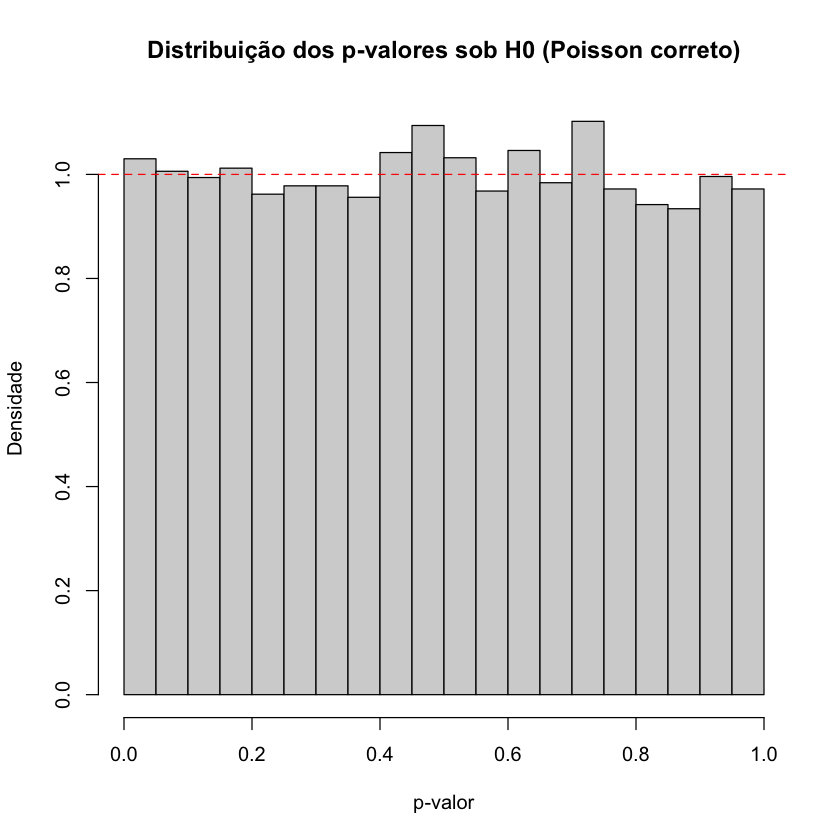

In [4]:
# ----------------------------------------------------------------------
# 2. Simulação de Monte Carlo sob H0 (beta1 = 0)
# ----------------------------------------------------------------------

beta1 = 0
valorp = numeric(M)

for(i in 1:M){
  y = rpois(n, exp(beta0 + beta1 * x))
  valorp[i] = teste_poisson(y, x)["p_lr"]
}

hist(valorp, prob=TRUE, col="lightgray",
     main="Distribuição dos p-valores sob H0 (Poisson correto)",
     xlab="p-valor", ylab="Densidade")

abline(h=1, lty=2, col="red")  # Uniforme(0,1)
cat("Média dos p-valores sob H0 =", mean(valorp), "\n")

Média dos p-valores sob H0 com superdispersão = 0.33324 


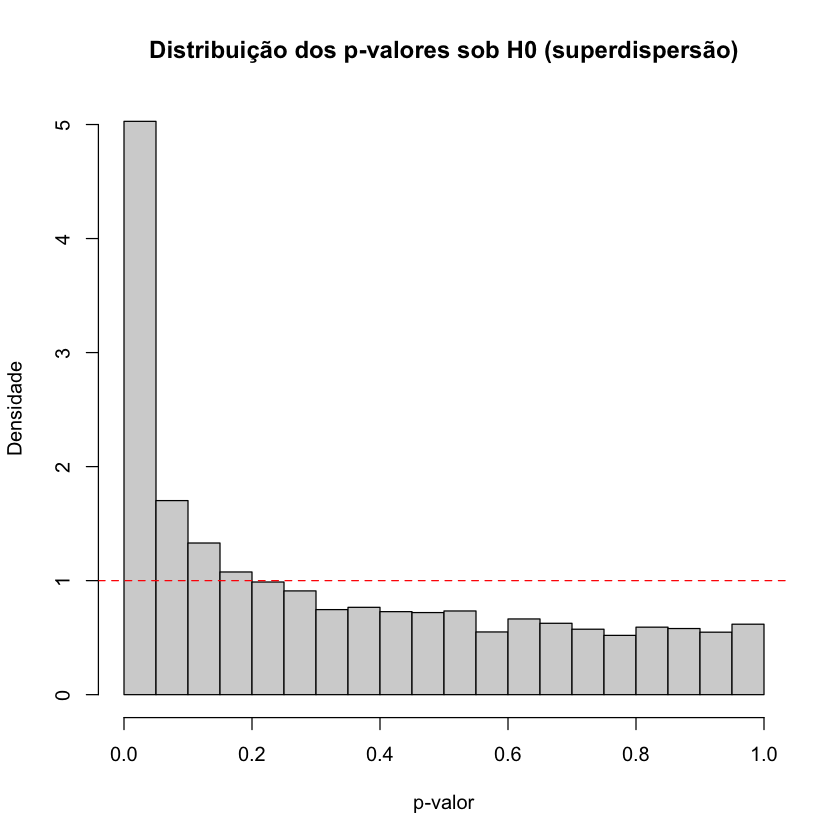

In [4]:
# ----------------------------------------------------------------------
# 3. Simulação sob violação (superdispersão)
# ----------------------------------------------------------------------

# Aqui geramos dados de uma mistura Poisson-Gamma (NegBin)
# mantendo o mesmo preditor linear mas com variância > média

beta1 = 0
phi = 2.0  # fator de superdispersão

valorp_sd = numeric(M)
for(i in 1:M){
  mu = exp(beta0 + beta1 * x)
  y  = rnbinom(n, size = mu/phi, mu = mu)
  valorp_sd[i] = teste_poisson(y, x)["p_lr"]
}

hist(valorp_sd, prob=TRUE, col="lightgray",
     main="Distribuição dos p-valores sob H0 (superdispersão)",
     xlab="p-valor", ylab="Densidade")

abline(h=1, lty=2, col="red")

cat("Média dos p-valores sob H0 com superdispersão =", mean(valorp_sd), "\n")


Proporção de rejeição (p < 0.05) = 0.9924 


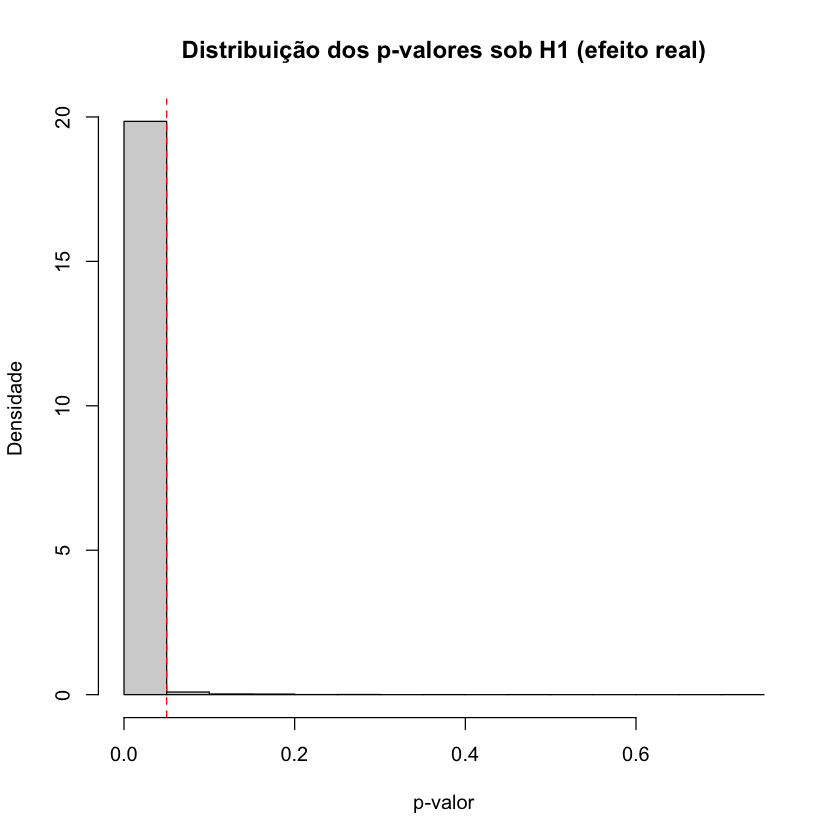

In [5]:

# ----------------------------------------------------------------------
# 4. Simulação sob H1 (efeito presente)
# ----------------------------------------------------------------------

beta1 = 0.3
valorp_alt = numeric(M)

for(i in 1:M){
  mu = exp(beta0 + beta1 * x)
  y  = rpois(n, mu)
  valorp_alt[i] = teste_poisson(y, x)["p_lr"]
}

hist(valorp_alt, prob=TRUE, col="lightgray",
     main="Distribuição dos p-valores sob H1 (efeito real)",
     xlab="p-valor", ylab="Densidade")

abline(v=alpha, lty=2, col="red")
cat("Proporção de rejeição (p < 0.05) =", mean(valorp_alt < alpha), "\n")

In [5]:
# ================================================================
# Exemplos numéricos — Regressão Poisson (um único dataset por cenário)
# ================================================================

set.seed(123)

# Parâmetros fixos
n = 200
beta0 = 1
alpha = 0.05

# Gera a covariável (mesma x para todos os cenários p/ comparabilidade)
x = runif(n, 0, 2)

# Função auxiliar: ajusta GLM Poisson e testa H0: beta1 = 0 em UM dataset
teste_poisson = function(y, x) {
  # Modelo completo e reduzido
  m_full = glm(y ~ x, family = poisson)
  m_red  = glm(y ~ 1, family = poisson)

  # Razão de verossimilhanças (LR) ~ Chi2_1 sob H0
  LR = 2 * (logLik(m_full)[1] - logLik(m_red)[1])
  p_lr = 1 - pchisq(LR, df = 1)

  # Wald para beta1: (beta1_hat / se)^2 ~ Chi2_1 sob H0
  b1_hat = coef(m_full)[2]
  se_b1  = sqrt(vcov(m_full)[2, 2])
  W = (b1_hat / se_b1)^2
  p_w = 1 - pchisq(W, df = 1)

  c(p_lr = p_lr, p_w = p_w, beta1_hat = b1_hat, se_b1 = se_b1, LR = LR, W = W)
}

# ------------------------------
# Cenário A — H0 verdadeira
# ------------------------------
beta1_A = 0.00
lambda_A = exp(beta0 + beta1_A * x)
y_A = rpois(n, lambda = lambda_A)

res_A = teste_poisson(y_A, x)

# ------------------------------
# Cenário B — H0 falsa (efeito fraco)
# ------------------------------
beta1_B = 0.15
lambda_B = exp(beta0 + beta1_B * x)
y_B = rpois(n, lambda = lambda_B)

res_B = teste_poisson(y_B, x)

# ------------------------------
# Cenário C — H0 falsa (efeito forte)
# ------------------------------
beta1_C = 0.60
lambda_C = exp(beta0 + beta1_C * x)
y_C = rpois(n, lambda = lambda_C)

res_C = teste_poisson(y_C, x)

# Mostra um resumo comparando os três cenários
round(rbind(
  "Cenário A (H0 verdadeira, beta1=0.00)" = res_A,
  "Cenário B (H0 falsa, beta1=0.15)"      = res_B,
  "Cenário C (H0 falsa, beta1=0.60)"      = res_C
), 4)

,p_lr,p_w.x,beta1_hat.x,se_b1,LR,W.x
"Cenário A (H0 verdadeira, beta1=0.00)",0.2100,0.2104,-0.0992,0.0792,1.5717,1.5683
"Cenário B (H0 falsa, beta1=0.15)",0.1676,0.1675,0.0998,0.0723,1.9043,1.9053
"Cenário C (H0 falsa, beta1=0.60)",0.0000,0.0000,0.6242,0.0579,119.0368,116.1481


In [6]:
# ================================================================
# Exemplos numéricos — Regressão Poisson (um único dataset por cenário)
# ================================================================

set.seed(123)

# Parâmetros fixos
n = 200
beta0 = 1
alpha = 0.05

# Gera a covariável (mesma x para todos os cenários p/ comparabilidade)
x = runif(n, 0, 2)

# Função auxiliar: ajusta GLM Poisson e testa H0: beta1 = 0 em UM dataset
teste_poisson = function(y, x) {
  # Modelo completo e reduzido
  m_full = glm(y ~ x, family = poisson)
  m_red  = glm(y ~ 1, family = poisson)

  # Razão de verossimilhanças (LR) ~ Chi2_1 sob H0
  LR = 2 * (logLik(m_full)[1] - logLik(m_red)[1])
  p_LR = 1 - pchisq(LR, df = 1)

  # Wald para beta1: (beta1_hat / se)^2 ~ Chi2_1 sob H0
  beta1_hat = coef(m_full)[2]
  se_beta1  = sqrt(vcov(m_full)[2, 2])
  W = (beta1_hat / se_beta1)^2
  p_W = 1 - pchisq(W, df = 1)

  data.frame(
    p_LR = p_LR,
    p_W = p_W,
    beta1_hat = beta1_hat,
    se_beta1 = se_beta1,
    LR = LR,
    W = W
  )
}

# ------------------------------
# Cenário A — H0 verdadeira
# ------------------------------
beta1_A = 0.00
lambda_A = exp(beta0 + beta1_A * x)
y_A = rpois(n, lambda = lambda_A)
res_A = teste_poisson(y_A, x)

# ------------------------------
# Cenário B — H0 falsa (efeito fraco)
# ------------------------------
beta1_B = 0.15
lambda_B = exp(beta0 + beta1_B * x)
y_B = rpois(n, lambda = lambda_B)
res_B = teste_poisson(y_B, x)

# ------------------------------
# Cenário C — H0 falsa (efeito forte)
# ------------------------------
beta1_C = 0.60
lambda_C = exp(beta0 + beta1_C * x)
y_C = rpois(n, lambda = lambda_C)
res_C = teste_poisson(y_C, x)

# Junta os resultados
resumo = rbind(
  "Cenário A (H0 verdadeira, beta1=0.00)" = res_A,
  "Cenário B (H0 falsa, beta1=0.15)"      = res_B,
  "Cenário C (H0 falsa, beta1=0.60)"      = res_C
)

# Mostra arredondado
round(resumo, 4)

,p_LR,p_W,beta1_hat,se_beta1,LR,W
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"Cenário A (H0 verdadeira, beta1=0.00)",0.2100,0.2104,-0.0992,0.0792,1.5717,1.5683
"Cenário B (H0 falsa, beta1=0.15)",0.1676,0.1675,0.0998,0.0723,1.9043,1.9053
"Cenário C (H0 falsa, beta1=0.60)",0.0000,0.0000,0.6242,0.0579,119.0368,116.1481


In [7]:
# ================================================================
# Exemplos numéricos — Regressão Poisson (um único dataset por cenário)
# ================================================================

set.seed(123)

# Parâmetros fixos
n = 200
beta0 = 1
alpha = 0.05

# Gera a covariável (mesma x para todos os cenários p/ comparabilidade)
x = runif(n, 0, 2)

# ---------------------------------------------------------------
# Função auxiliar: ajusta GLM Poisson e testa H0: beta1 = 0
# ---------------------------------------------------------------
teste_poisson = function(y, x) {
  
  # Modelo completo e modelo reduzido
  modelo_completo = glm(y ~ x, family = poisson)
  modelo_reduzido = glm(y ~ 1, family = poisson)
  
  # Estatística da Razão de Verossimilhanças (LR)
  razao_verossimilhanca = 2 * (logLik(modelo_completo)[1] - logLik(modelo_reduzido)[1])
  p_valor_LR = 1 - pchisq(razao_verossimilhanca, df = 1)
  
  # Estatística de Wald
  beta1_estimado = coef(modelo_completo)[2]
  erro_padrao_beta1 = sqrt(vcov(modelo_completo)[2, 2])
  estatistica_Wald = (beta1_estimado / erro_padrao_beta1)^2
  p_valor_Wald = 1 - pchisq(estatistica_Wald, df = 1)
  
  # Retorna resultados
  data.frame(
    p_valor_LR = p_valor_LR,
    p_valor_Wald = p_valor_Wald,
    beta1_estimado = beta1_estimado,
    erro_padrao_beta1 = erro_padrao_beta1,
    estatistica_LR = razao_verossimilhanca,
    estatistica_Wald = estatistica_Wald
  )
}

# ------------------------------
# Cenário A — H0 verdadeira
# ------------------------------
beta1_A = 0.00
lambda_A = exp(beta0 + beta1_A * x)
y_A = rpois(n, lambda = lambda_A)
resultado_A = teste_poisson(y_A, x)

# ------------------------------
# Cenário B — H0 falsa (efeito fraco)
# ------------------------------
beta1_B = 0.15
lambda_B = exp(beta0 + beta1_B * x)
y_B = rpois(n, lambda = lambda_B)
resultado_B = teste_poisson(y_B, x)

# ------------------------------
# Cenário C — H0 falsa (efeito forte)
# ------------------------------
beta1_C = 0.60
lambda_C = exp(beta0 + beta1_C * x)
y_C = rpois(n, lambda = lambda_C)
resultado_C = teste_poisson(y_C, x)

# Junta os resultados
resumo_resultados = rbind(
  "Cenário A (H0 verdadeira, beta1=0.00)" = resultado_A,
  "Cenário B (H0 falsa, beta1=0.15)"      = resultado_B,
  "Cenário C (H0 falsa, beta1=0.60)"      = resultado_C
)

# Mostra arredondado
round(resumo_resultados, 4)

,p_valor_LR,p_valor_Wald,beta1_estimado,erro_padrao_beta1,estatistica_LR,estatistica_Wald
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"Cenário A (H0 verdadeira, beta1=0.00)",0.2100,0.2104,-0.0992,0.0792,1.5717,1.5683
"Cenário B (H0 falsa, beta1=0.15)",0.1676,0.1675,0.0998,0.0723,1.9043,1.9053
"Cenário C (H0 falsa, beta1=0.60)",0.0000,0.0000,0.6242,0.0579,119.0368,116.1481


In [8]:
# ================================================================
# Simulação simples — valor-p, decisão e comparação com valor real
# ================================================================

set.seed(123)

# Parâmetros
n = 200
beta0 = 1
alpha = 0.05        # nível de significância
beta_real = c(0, 0.2, 0.6)   # três valores reais para testar

# Covariável
x = runif(n, 0, 2)

# Função para gerar dados e calcular o valor-p
teste_simples = function(beta1_real) {
  lambda = exp(beta0 + beta1_real * x)
  y = rpois(n, lambda)
  modelo = glm(y ~ x, family = poisson)
  
  beta1_est = coef(modelo)[2]
  erro_beta1 = sqrt(vcov(modelo)[2, 2])
  z = beta1_est / erro_beta1
  p_valor = 2 * (1 - pnorm(abs(z)))    # teste bicaudal
  
  decisao = ifelse(p_valor < alpha, "Rejeita H0", "Não rejeita H0")
  
  data.frame(
    valor_p = round(p_valor, 4),
    decisao = decisao,
    beta1_estimado = round(beta1_est, 4),
    beta1_real = beta1_real
  )
}

# Executa os três cenários
resultados = do.call(rbind, lapply(beta_real, teste_simples))
rownames(resultados) = c("Cenário A", "Cenário B", "Cenário C")

print(resultados)

          valor_p        decisao beta1_estimado beta1_real
Cenário A  0.2104 Não rejeita H0        -0.0992        0.0
Cenário B  0.0617 Não rejeita H0         0.1318        0.2
Cenário C  0.0000     Rejeita H0         0.6242        0.6


Resultado do teste KS:

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  valores_p
D = 0.0083031, p-value = 0.4957
alternative hypothesis: two-sided



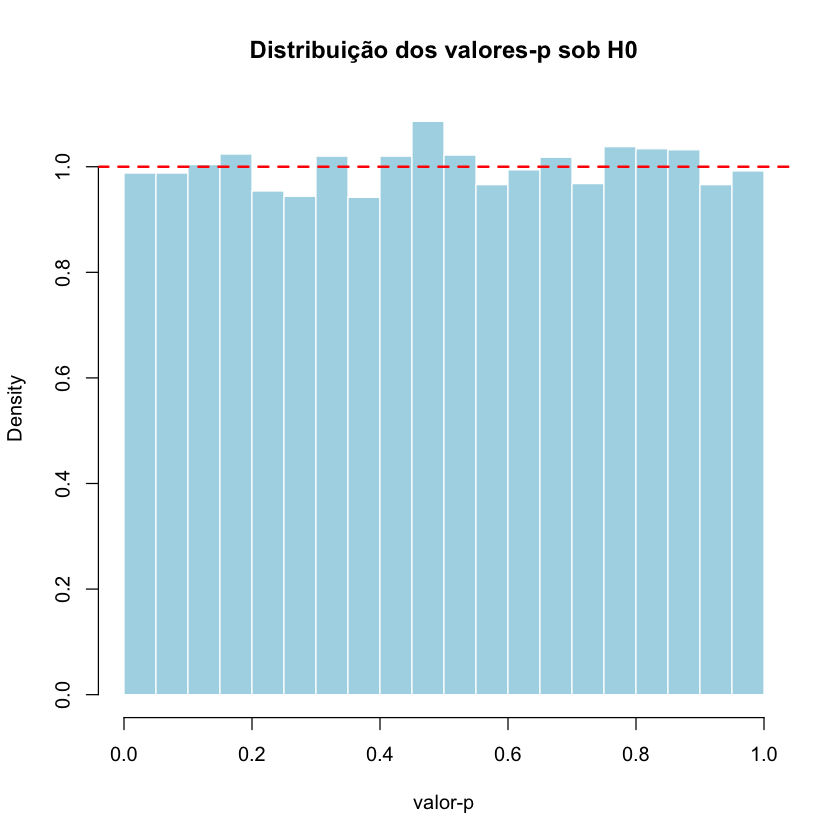

In [9]:
# ================================================================
# Teste da uniformidade dos valores-p sob H0
# ================================================================

set.seed(123)

# Parâmetros
n = 200
beta0 = 1
beta1 = 0      # H0 verdadeira
alpha = 0.05
M = 10000      # número de simulações

x = runif(n, 0, 2)
valores_p = numeric(M)

for (i in 1:M) {
  lambda = exp(beta0 + beta1 * x)
  y = rpois(n, lambda)
  modelo = glm(y ~ x, family = poisson)
  
  beta1_est = coef(modelo)[2]
  erro_beta1 = sqrt(vcov(modelo)[2, 2])
  z = beta1_est / erro_beta1
  valores_p[i] = 2 * (1 - pnorm(abs(z)))  # teste bicaudal
}

# Histograma visual
hist(valores_p, breaks = 30, prob = TRUE, main = "Distribuição dos valores-p sob H0",
     xlab = "valor-p", col = "lightblue", border = "white")
abline(h = 1, col = "red", lwd = 2, lty = 2)  # linha da densidade uniforme

# Teste KS contra U(0,1)
ks = ks.test(valores_p, "punif")

cat("Resultado do teste KS:\n")
print(ks)